In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
#maxEvents = 10000
#maxEvents = 200000
maxEvents = 2000000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

superstrip_size = 16

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def delta_phi(lhs, rhs):  # in radians
  rad = lhs - rhs
  while rad <  -np.pi:  rad += np.pi*2
  while rad >= +np.pi:  rad -= np.pi*2
  return rad

def delta_theta(lhs, rhs):  # in radians
  rad = lhs - rhs
  return rad

def range_phi_deg(deg):
  while deg <  -180.:
    deg += 360.
  while deg >= +180.:
    deg -= 360.
  return deg

def calc_phi_loc_deg_from_glob(glob, sector):
  # glob in deg, sector [1-6]
  glob = range_phi_deg(glob)
  loc = glob - 15. - (60. * (sector-1))
  return loc

def calc_phi_loc_int(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  phi_int = int(round(loc))
  return phi_int

def calc_phi_loc_int_1(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  #phi_int = int(round(loc))
  phi_int = loc  # no cast to int
  return phi_int

def calc_theta_int(theta, endcap):
  # theta in deg, endcap [-1,+1]
  if endcap == -1:
    theta = 180. - theta
  theta = (theta - 8.5) * 128./(45.0-8.5)
  theta_int = int(round(theta))
  return theta_int

In [5]:
# Collect hits in ME1/1a, or ME1/1b, or ME1/2 from events 
# where the hits exist in the same sector, but different F/R.
# Calculate the difference in the integer phi unit and 
# the correction to the common plane use the bend.

class Collector(object):
  def __init__(self, select_fn, select_fn_2):
    self.select_fn = select_fn
    self.select_fn_2 = select_fn_2
  
  def run(self, hits):
    cached_hits = []
    found_f = False
    found_r = False
    for ihit, hit in enumerate(hits):
      if self.select_fn(hit) and self.select_fn_2(hit):
        if hit.fr == 1:
          found_f = True
        elif hit.fr == 0:
          found_r = True
        else:
          raise Exception('Expect only F or R')
        cached_hits.append(hit)
    
    found_same_sector = (len(set([hit.sector for hit in cached_hits])) == 1)
    found_fr_pair = (len(cached_hits) == 2)
    
    hit_f = None
    hit_r = None
    
    if found_f and found_r and found_same_sector and found_fr_pair:
      for ihit, hit in enumerate(cached_hits):
        hit.fph = calc_phi_loc_int_1(hit.sim_phi, hit.sector)
        hit.th = calc_theta_int(hit.sim_theta, hit.endcap)
        if abs(int(round(hit.fph)) - hit.emtf_phi) > 7:
          s = '{0}, {1}'.format(int(round(hit.fph)), hit.emtf_phi)
          raise Exception('Expect at most +/-7 correction, but: ' + s)

        if hit.fr == 1:
          hit_f = hit
        elif hit.fr == 0:
          hit_r = hit
        else:
          raise Exception('Expect only F or R')

      assert(hit_f is not None)
      assert(hit_r is not None)
      if abs(hit_r.chamber - hit_f.chamber) != 1 and abs(hit_r.chamber - hit_f.chamber) != (36-1):
        s = '{0}, {1}'.format(hit_r.chamber, hit_f.chamber)
        raise Exception('Expect chamber differ by 1, but: ' + s)

      return (0.5*(hit_r.fph - hit_f.fph), (hit_r.bend * hit_r.endcap), (hit_f.bend * hit_f.endcap))
    return (np.inf, np.inf, np.inf)

In [6]:
class GEMFinder(object):
  def __init__(self, select_fn, select_fn_2, select_fn_gem):
    self.select_fn = select_fn
    self.select_fn_2 = select_fn_2
    self.select_fn_gem = select_fn_gem
    
  def run(self, hits):
    cached_hits = []
    for ihit, hit in enumerate(hits):
      if self.select_fn(hit) and self.select_fn_2(hit):
        cached_hits.append(hit)
    
    cached_hits_gem = []
    for ihit, hit in enumerate(hits):
      if self.select_fn_gem(hit) and self.select_fn_2(hit):
        cached_hits_gem.append(hit)
    
    hit_csc = None
    if cached_hits:
      hit_phis = [hit.emtf_phi for hit in cached_hits]
      if (np.max(hit_phis) - np.min(hit_phis)) < 8*4:
        hit_csc = np.random.choice(cached_hits)
    
    hit_gem = None
    if cached_hits_gem:
      hit_phis = [hit.emtf_phi for hit in cached_hits_gem]
      if (np.max(hit_phis) - np.min(hit_phis)) < 8*4:
        hit_gem = np.random.choice(cached_hits_gem)
    return (hit_csc, hit_gem)

In [7]:
def process(verbose=1):
  tree = load_pgun()
  
  outs_me11a = []
  outs_me11b = []
  outs_me12 = []
  outs_gem_me11a = []
  outs_gem_me11b = []
  outs_gem_me12 = []
  
  select_fn_me11a = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 4)
  select_fn_me11b = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 1)
  select_fn_me12 = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 2)
  select_fn_ge11 = lambda hit: (hit.type == kGEM and hit.station == 1 and hit.ring == 1)
  
  #select_fn_2 = lambda hit: (hit.neighbor == 0 and hit.bx == 0 and hit.sim_tp1 == 0 and hit.sim_tp2 == 0)
  select_fn_2 = lambda hit: (hit.neighbor == 0 and hit.sim_tp1 == 0 and hit.sim_tp2 == 0)
  
  collector_me11a = Collector(select_fn_me11a, select_fn_2)
  collector_me11b = Collector(select_fn_me11b, select_fn_2)
  collector_me12 = Collector(select_fn_me12, select_fn_2)
  
  gemfinder_me11a = GEMFinder(select_fn_me11a, select_fn_2, select_fn_ge11)
  gemfinder_me11b = GEMFinder(select_fn_me11b, select_fn_2, select_fn_ge11)
  gemfinder_me12 = GEMFinder(select_fn_me12, select_fn_2, select_fn_ge11)

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break

    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
      
    # Skip events with pT < 3 GeV
    if evt.particles[0].pt < 3:
      continue

    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue

    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    if verbose and ievt < 20:
      print("evt {0} has {1} particles and {2} hits".format(ievt, len(evt.particles), len(evt.hits)))
      for ihit, hit in enumerate(evt.hits):
        hit.fph = calc_phi_loc_int_1(hit.sim_phi, hit.sector)
        hit.th = calc_theta_int(hit.sim_theta, hit.endcap)
        if abs(int(round(hit.fph)) - hit.emtf_phi) > 7:
          s = '{0}, {1}'.format(int(round(hit.fph)), hit.emtf_phi)
          raise Exception('Expect at most +/-7 correction, but: ' + s)
        print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} {12} {13}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2, hit.emtf_phi, hit.fph))
    
    (rf, bend_r, bend_f) = collector_me11a.run(evt.hits)
    if np.isfinite(rf):
      outs_me11a.append((part.invpt, rf, bend_r, bend_f))
    
    (rf, bend_r, bend_f) = collector_me11b.run(evt.hits)
    if np.isfinite(rf):
      outs_me11b.append((part.invpt, rf, bend_r, bend_f))
    
    (rf, bend_r, bend_f) = collector_me12.run(evt.hits)
    if np.isfinite(rf):
      outs_me12.append((part.invpt, rf, bend_r, bend_f))
    
    if 1.55 <= abs(part.eta) <= 2.15:
      (hit_csc, hit_gem) = gemfinder_me11a.run(evt.hits)
      if (hit_csc is not None) and (hit_gem is not None):
        outs_gem_me11a.append((part.invpt, hit_csc.fr, hit_csc.endcap, hit_csc.pattern, hit_csc.emtf_phi, hit_csc.bend, hit_gem.emtf_phi, hit_gem.bend))

      (hit_csc, hit_gem) = gemfinder_me11b.run(evt.hits)
      if (hit_csc is not None) and (hit_gem is not None):
        outs_gem_me11b.append((part.invpt, hit_csc.fr, hit_csc.endcap, hit_csc.pattern, hit_csc.emtf_phi, hit_csc.bend, hit_gem.emtf_phi, hit_gem.bend))

      (hit_csc, hit_gem) = gemfinder_me12.run(evt.hits)
      if (hit_csc is not None) and (hit_gem is not None):
        outs_gem_me12.append((part.invpt, hit_csc.fr, hit_csc.endcap, hit_csc.pattern, hit_csc.emtf_phi, hit_csc.bend, hit_gem.emtf_phi, hit_gem.bend))

  return (np.asarray(outs_me11a), np.asarray(outs_me11b), np.asarray(outs_me12), 
          np.asarray(outs_gem_me11a), np.asarray(outs_gem_me11b), np.asarray(outs_gem_me12))

In [8]:
outs_me11a, outs_me11b, outs_me12, outs_gem_me11a, outs_gem_me11b, outs_gem_me12 = process()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
evt 4 has 1 particles and 9 hits
.. hit  0 0 1 1 2 4 0 -163.266098022 28.40467453 0 0 0 1425 1424.03411865
.. hit  1 0 1 1 2 4 0 -163.265975952 29.4308719635 0 0 -1 1425 1424.04144287
.. hit  2 0 2 1 2 4 0 -162.978622437 27.7948722839 -50 0 0 1440 1441.28265381
.. hit  3 0 1 2 2 4 0 -162.734024048 28.0849151611 0 0 0 1455 1455.95855713
.. hit  4 0 2 2 2 4 0 -162.661026001 27.230890274 -21 0 0 1460 1460.33843994
.. hit  5 0 1 3 2 4 1 -163.000335693 27.8482627869 0 0 0 1440 1439.9798584
.. hit  6 0 2 3 3 4 0 -163.285934448 28.7258625031 23 0 0 1424 1422.84393311
.. hit  7 0 1 4 2 4 1 -163.534225464 28.0116901398 0 0 0 1408 1407.94647217
.. hit  8 0 2 4 3 4 0 -163.910064697 29.5494651794 19 0 0 1384 1385.39611816
evt 5 has 1 particles and 9 hits
.. hit  0 0 3 1 1 3 1 171.668624878 19.8607978821 0 0 0 3520 3520.11749268
.. hit  1 0 3 1 1 3 1 171.721572876 19.8613014221 0 0 0 3523 3523.29437256
.. hit  2

Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processing event: 39000
Processing event: 40000
Processing event: 41000
Processing event: 42000
P

Processing event: 334000
Processing event: 335000
Processing event: 336000
Processing event: 337000
Processing event: 338000
Processing event: 339000
Processing event: 340000
Processing event: 341000
Processing event: 342000
Processing event: 343000
Processing event: 344000
Processing event: 345000
Processing event: 346000
Processing event: 347000
Processing event: 348000
Processing event: 349000
Processing event: 350000
Processing event: 351000
Processing event: 352000
Processing event: 353000
Processing event: 354000
Processing event: 355000
Processing event: 356000
Processing event: 357000
Processing event: 358000
Processing event: 359000
Processing event: 360000
Processing event: 361000
Processing event: 362000
Processing event: 363000
Processing event: 364000
Processing event: 365000
Processing event: 366000
Processing event: 367000
Processing event: 368000
Processing event: 369000
Processing event: 370000
Processing event: 371000
Processing event: 372000
Processing event: 373000


Processing event: 662000
Processing event: 663000
Processing event: 664000
Processing event: 665000
Processing event: 666000
Processing event: 667000
Processing event: 668000
Processing event: 669000
Processing event: 670000
Processing event: 671000
Processing event: 672000
Processing event: 673000
Processing event: 674000
Processing event: 675000
Processing event: 676000
Processing event: 677000
Processing event: 678000
Processing event: 679000
Processing event: 680000
Processing event: 681000
Processing event: 682000
Processing event: 683000
Processing event: 684000
Processing event: 685000
Processing event: 686000
Processing event: 687000
Processing event: 688000
Processing event: 689000
Processing event: 690000
Processing event: 691000
Processing event: 692000
Processing event: 693000
Processing event: 694000
Processing event: 695000
Processing event: 696000
Processing event: 697000
Processing event: 698000
Processing event: 699000
Processing event: 700000
Processing event: 701000


Processing event: 990000
Processing event: 991000
Processing event: 992000
Processing event: 993000
Processing event: 994000
Processing event: 995000
Processing event: 996000
Processing event: 997000
Processing event: 998000
Processing event: 999000
Processing event: 1000000
Processing event: 1001000
Processing event: 1002000
Processing event: 1003000
Processing event: 1004000
Processing event: 1005000
Processing event: 1006000
Processing event: 1007000
Processing event: 1008000
Processing event: 1009000
Processing event: 1010000
Processing event: 1011000
Processing event: 1012000
Processing event: 1013000
Processing event: 1014000
Processing event: 1015000
Processing event: 1016000
Processing event: 1017000
Processing event: 1018000
Processing event: 1019000
Processing event: 1020000
Processing event: 1021000
Processing event: 1022000
Processing event: 1023000
Processing event: 1024000
Processing event: 1025000
Processing event: 1026000
Processing event: 1027000
Processing event: 1028

Processing event: 1306000
Processing event: 1307000
Processing event: 1308000
Processing event: 1309000
Processing event: 1310000
Processing event: 1311000
Processing event: 1312000
Processing event: 1313000
Processing event: 1314000
Processing event: 1315000
Processing event: 1316000
Processing event: 1317000
Processing event: 1318000
Processing event: 1319000
Processing event: 1320000
Processing event: 1321000
Processing event: 1322000
Processing event: 1323000
Processing event: 1324000
Processing event: 1325000
Processing event: 1326000
Processing event: 1327000
Processing event: 1328000
Processing event: 1329000
Processing event: 1330000
Processing event: 1331000
Processing event: 1332000
Processing event: 1333000
Processing event: 1334000
Processing event: 1335000
Processing event: 1336000
Processing event: 1337000
Processing event: 1338000
Processing event: 1339000
Processing event: 1340000
Processing event: 1341000
Processing event: 1342000
Processing event: 1343000
Processing e

Processing event: 1622000
Processing event: 1623000
Processing event: 1624000
Processing event: 1625000
Processing event: 1626000
Processing event: 1627000
Processing event: 1628000
Processing event: 1629000
Processing event: 1630000
Processing event: 1631000
Processing event: 1632000
Processing event: 1633000
Processing event: 1634000
Processing event: 1635000
Processing event: 1636000
Processing event: 1637000
Processing event: 1638000
Processing event: 1639000
Processing event: 1640000
Processing event: 1641000
Processing event: 1642000
Processing event: 1643000
Processing event: 1644000
Processing event: 1645000
Processing event: 1646000
Processing event: 1647000
Processing event: 1648000
Processing event: 1649000
Processing event: 1650000
Processing event: 1651000
Processing event: 1652000
Processing event: 1653000
Processing event: 1654000
Processing event: 1655000
Processing event: 1656000
Processing event: 1657000
Processing event: 1658000
Processing event: 1659000
Processing e

Processing event: 1938000
Processing event: 1939000
Processing event: 1940000
Processing event: 1941000
Processing event: 1942000
Processing event: 1943000
Processing event: 1944000
Processing event: 1945000
Processing event: 1946000
Processing event: 1947000
Processing event: 1948000
Processing event: 1949000
Processing event: 1950000
Processing event: 1951000
Processing event: 1952000
Processing event: 1953000
Processing event: 1954000
Processing event: 1955000
Processing event: 1956000
Processing event: 1957000
Processing event: 1958000
Processing event: 1959000
Processing event: 1960000
Processing event: 1961000
Processing event: 1962000
Processing event: 1963000
Processing event: 1964000
Processing event: 1965000
Processing event: 1966000
Processing event: 1967000
Processing event: 1968000
Processing event: 1969000
Processing event: 1970000
Processing event: 1971000
Processing event: 1972000
Processing event: 1973000
Processing event: 1974000
Processing event: 1975000
Processing e

In [9]:
print outs_me11a.shape, outs_me11b.shape, outs_me12.shape, outs_gem_me11a.shape, outs_gem_me11b.shape, outs_gem_me12.shape

(4040, 4) (14073, 4) (11739, 4) (54996, 8) (468550, 8) (37811, 8)


In [10]:
# Save

outfile = 'frontrear_out.npz'
np.savez_compressed(outfile, outs_me11a=outs_me11a, outs_me11b=outs_me11b, outs_me12=outs_me12, outs_gem_me11a=outs_gem_me11a, outs_gem_me11b=outs_gem_me11b, outs_gem_me12=outs_gem_me12)

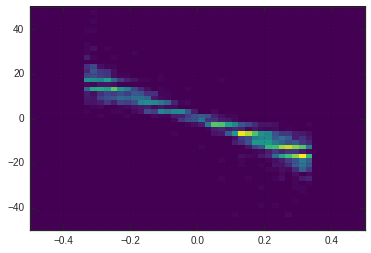

In [12]:
x = outs_me11a[:,0]  # q/pt
y = outs_me11a[:,1]  # dist = 0.5(r-f)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-0.5,0.5),(-50,50)))
plt.show()

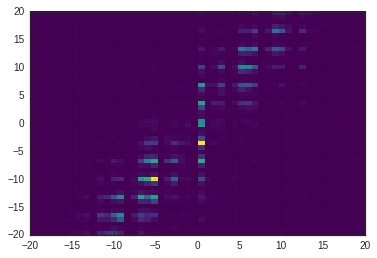

In [13]:
x = outs_me11a[:,2]  # bend_r
y = outs_me11a[:,1]  # dist = 0.5(r-f)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
plt.show()

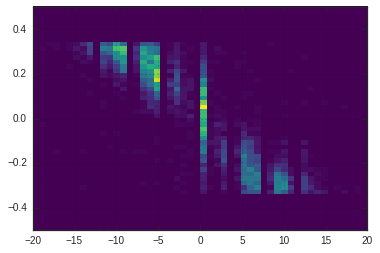

In [14]:
x = outs_me11a[:,2]  # bend_r
y = outs_me11a[:,0]  # q/pt

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-0.5,0.5)))
plt.show()

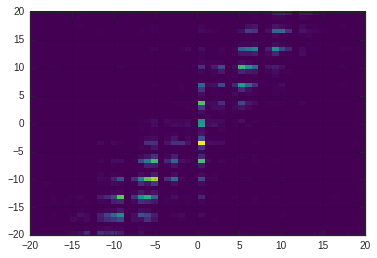

In [15]:
x = outs_me11a[:,3]  # bend_f
y = outs_me11a[:,1]  # dist = 0.5(r-f)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
plt.show()

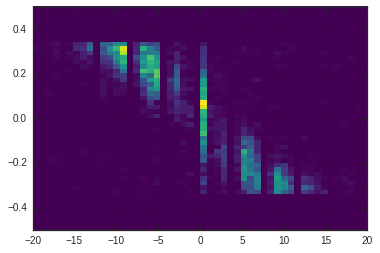

In [16]:
x = outs_me11a[:,3]  # bend_f
y = outs_me11a[:,0]  # q/pt

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-0.5,0.5)))
plt.show()

0.0 [1.52476755]
0.0 [1.64192093]


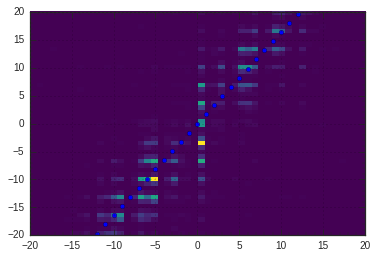

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor

x = outs_me11a[:,2]  # bend_r
y = outs_me11a[:,1]  # dist = 0.5(r-f)

rid = Ridge(fit_intercept=False,alpha=0.1)
rid.fit(np.atleast_2d(x).T, y)
huber = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.35)
huber.fit(np.atleast_2d(x).T, y)
print rid.intercept_, rid.coef_
print huber.intercept_, huber.coef_

xx = np.linspace(-20,20,num=41)
yy = huber.predict(np.atleast_2d(xx).T)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
ax.scatter(xx, yy)
plt.show()

0.0 [1.3571402]
0.0 [1.60119111]


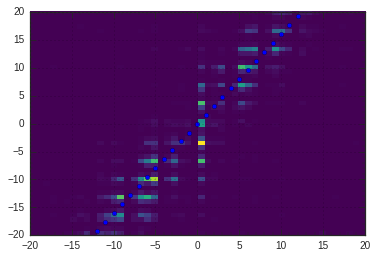

In [18]:
x = outs_me11a[:,3]  # bend_f
y = outs_me11a[:,1]  # dist = 0.5(r-f)

rid = Ridge(fit_intercept=False,alpha=0.1)
rid.fit(np.atleast_2d(x).T, y)
huber = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.35)
huber.fit(np.atleast_2d(x).T, y)
print rid.intercept_, rid.coef_
print huber.intercept_, huber.coef_

xx = np.linspace(-20,20,num=41)
yy = huber.predict(np.atleast_2d(xx).T)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
ax.scatter(xx, yy)
plt.show()

In [19]:
def doit():
  for x, y, label in xy:
    print label
    lin = LinearRegression(fit_intercept=False)
    lin.fit(np.atleast_2d(x).T, y)
    print lin.intercept_, lin.coef_
    rid1 = Ridge(fit_intercept=False,alpha=1)
    rid1.fit(np.atleast_2d(x).T, y)
    print rid1.intercept_, rid1.coef_
    rid2 = Ridge(fit_intercept=False,alpha=0.1)
    rid2.fit(np.atleast_2d(x).T, y)
    print rid2.intercept_, rid2.coef_
    rid3 = Ridge(fit_intercept=False,alpha=0.01)
    rid3.fit(np.atleast_2d(x).T, y)
    print rid3.intercept_, rid3.coef_
    huber1 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.35)
    huber1.fit(np.atleast_2d(x).T, y)
    print huber1.intercept_, huber1.coef_
    huber2 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.5)
    huber2.fit(np.atleast_2d(x).T, y)
    print huber2.intercept_, huber2.coef_
    huber3 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=2.0)
    huber3.fit(np.atleast_2d(x).T, y)
    print huber3.intercept_, huber3.coef_
    huber4 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=3.0)
    huber4.fit(np.atleast_2d(x).T, y)
    print huber4.intercept_, huber4.coef_

In [20]:
# ME1/1a
xy = [
  (outs_me11a[:,2], outs_me11a[:,1], 'x: bend_r, y: dist'),
  (outs_me11a[:,2], outs_me11a[:,0], 'x: bend_r, y: q/pt'),
  (outs_me11a[:,3], outs_me11a[:,1], 'x: bend_f, y: dist'),
  (outs_me11a[:,3], outs_me11a[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [1.52476829]
0.0 [1.52476086]
0.0 [1.52476755]
0.0 [1.52476822]
0.0 [1.64192093]
0.0 [1.63597848]
0.0 [1.61347273]
0.0 [1.58861952]
x: bend_r, y: q/pt
0.0 [-0.0271244]
0.0 [-0.02712427]
0.0 [-0.02712439]
0.0 [-0.0271244]
0.0 [-0.02946533]
0.0 [-0.02940322]
0.0 [-0.02904912]
0.0 [-0.02846895]
x: bend_f, y: dist
0.0 [1.3571408]
0.0 [1.35713481]
0.0 [1.3571402]
0.0 [1.35714074]
0.0 [1.60119111]
0.0 [1.59419332]
0.0 [1.57338095]
0.0 [1.53661659]
x: bend_f, y: q/pt
0.0 [-0.02471934]
0.0 [-0.02471923]
0.0 [-0.02471933]
0.0 [-0.02471934]
0.0 [-0.02852313]
0.0 [-0.02842153]
0.0 [-0.02790443]
0.0 [-0.02703527]


In [21]:
# ME1/1b
xy = [
  (outs_me11b[:,2], outs_me11b[:,1], 'x: bend_r, y: dist'),
  (outs_me11b[:,2], outs_me11b[:,0], 'x: bend_r, y: q/pt'),
  (outs_me11b[:,3], outs_me11b[:,1], 'x: bend_f, y: dist'),
  (outs_me11b[:,3], outs_me11b[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [1.36612817]
0.0 [1.36612769]
0.0 [1.36612813]
0.0 [1.36612817]
0.0 [1.38614441]
0.0 [1.38565572]
0.0 [1.3835236]
0.0 [1.37979681]
x: bend_r, y: q/pt
0.0 [-0.01449031]
0.0 [-0.01449031]
0.0 [-0.01449031]
0.0 [-0.01449031]
0.0 [-0.01483228]
0.0 [-0.01480662]
0.0 [-0.0147341]
0.0 [-0.01463459]
x: bend_f, y: dist
0.0 [1.32868479]
0.0 [1.32868433]
0.0 [1.32868474]
0.0 [1.32868479]
0.0 [1.36921065]
0.0 [1.36779475]
0.0 [1.36497459]
0.0 [1.359537]
x: bend_f, y: q/pt
0.0 [-0.01418034]
0.0 [-0.01418034]
0.0 [-0.01418034]
0.0 [-0.01418034]
0.0 [-0.01463984]
0.0 [-0.01461228]
0.0 [-0.01452691]
0.0 [-0.01441725]


In [22]:
# ME1/2
xy = [
  (outs_me12[:,2], outs_me12[:,1], 'x: bend_r, y: dist'),
  (outs_me12[:,2], outs_me12[:,0], 'x: bend_r, y: q/pt'),
  (outs_me12[:,3], outs_me12[:,1], 'x: bend_f, y: dist'),
  (outs_me12[:,3], outs_me12[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [0.91419185]
0.0 [0.91419152]
0.0 [0.91419182]
0.0 [0.91419185]
0.0 [0.9237216]
0.0 [0.92353823]
0.0 [0.92213851]
0.0 [0.92016608]
x: bend_r, y: q/pt
0.0 [-0.01200454]
0.0 [-0.01200454]
0.0 [-0.01200454]
0.0 [-0.01200454]
0.0 [-0.01222399]
0.0 [-0.01219264]
0.0 [-0.01214106]
0.0 [-0.0120968]
x: bend_f, y: dist
0.0 [0.82226916]
0.0 [0.82226892]
0.0 [0.82226913]
0.0 [0.82226915]
0.0 [0.82873967]
0.0 [0.8288777]
0.0 [0.82775464]
0.0 [0.82683974]
x: bend_f, y: q/pt
0.0 [-0.01085391]
0.0 [-0.0108539]
0.0 [-0.01085391]
0.0 [-0.01085391]
0.0 [-0.01101681]
0.0 [-0.01099681]
0.0 [-0.01094379]
0.0 [-0.01090659]


In [37]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [38]:
def doit():
  data_5GeV_r = []
  data_5GeV_f = []
  data_20GeV_r = []
  data_20GeV_f = []

  xscale = (1./60) * (np.pi/180)

  for (invpt, fr, endcap, pattern, csc_phi, csc_bend, gem_phi, gem_bend) in gems:
    if apply_correction:
      # Remove patt_corr
      ph_pattern_corr = [0, 0, 5, 5, 5, 5, 2, 2, 2, 2, 0]
      ph_pattern_corr_sign = [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
      patt_corr = ph_pattern_corr[int(pattern)]
      patt_corr_sign = ph_pattern_corr_sign[int(pattern)]
      patt_corr_sign = 1 if patt_corr_sign == 0 else -1
      patt_corr_sign = patt_corr_sign if endcap == 1 else (patt_corr_sign * -1)
      patt_corr = (patt_corr >> 1)  # 10 degree
      patt_corr = patt_corr * patt_corr_const
      csc_phi = csc_phi - (patt_corr * patt_corr_sign)

      # Add bend_corr
      bend_corr = bend_corr_const[int(fr)]
      bend_corr = bend_corr if endcap == 1 else (bend_corr * -1)
      csc_phi = csc_phi + (bend_corr * csc_bend)

      # Integer
      csc_phi = round(csc_phi)
    
    # GEM-CSC angle
    pt = np.abs(1.0/invpt)
    q = np.sign(invpt)
    dphi = (gem_phi - csc_phi) * q
    if dphi < 1800.:
      dphi += 3600.
    if dphi >= 1800.:
      dphi -= 3600.
    dphi = int(dphi)
    dphi *= xscale

    if (5 <= pt <= 10):
      if fr == 0:
        data_5GeV_r.append(dphi)
      else:
        data_5GeV_f.append(dphi)
    elif (20 <= pt <= 40):
      if fr == 0:
        data_20GeV_r.append(dphi)
      else:
        data_20GeV_f.append(dphi)
  return np.asarray(data_5GeV_r), np.asarray(data_5GeV_f), np.asarray(data_20GeV_r), np.asarray(data_20GeV_f)

### ME1/1b

In [39]:
apply_correction = False
gems = outs_gem_me11b
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(72608,) (71637,) (18301,) (17942,)
0.01121527324800577 0.005300745983600015 0.002651992559939802 0.0012331377299696121


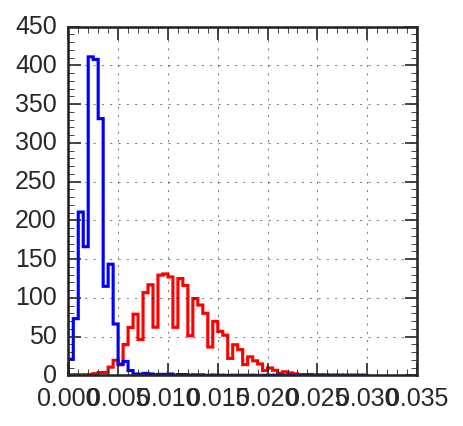

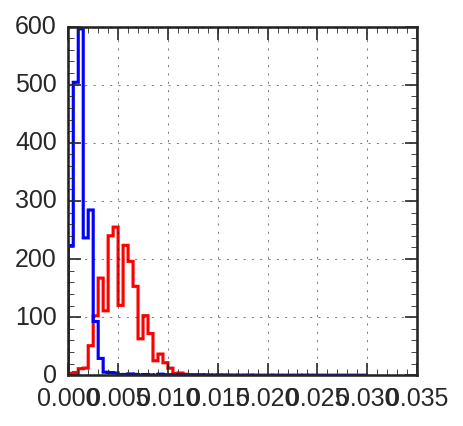

In [40]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='r')
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='b')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='r')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='b')
plt.show()

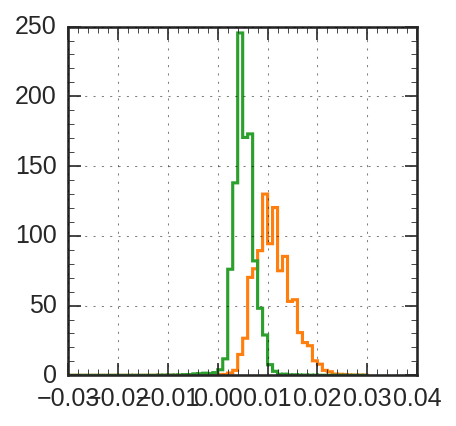

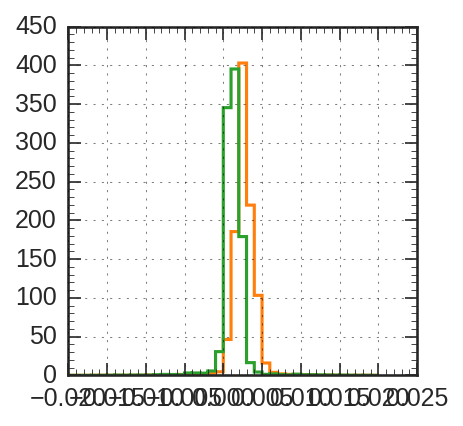

In [41]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

In [42]:
apply_correction = True
gems = outs_gem_me11b
patt_corr_const = (1301. / 1024.)  # ME1/1b
bend_corr_const = [-1.3861, 1.3692]  # ME1/1b (r,f)
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(72608,) (71637,) (18301,) (17942,)
0.00781477214055487 0.008429520991008724 0.0018928476097139382 0.0019352285713623819


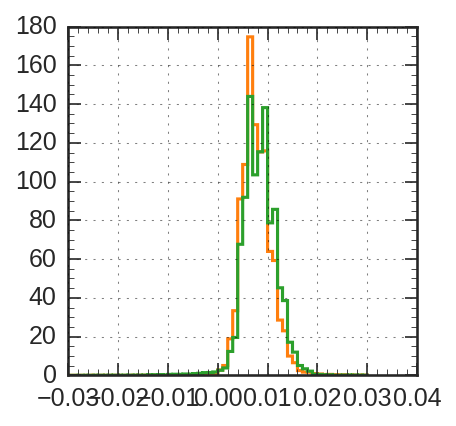

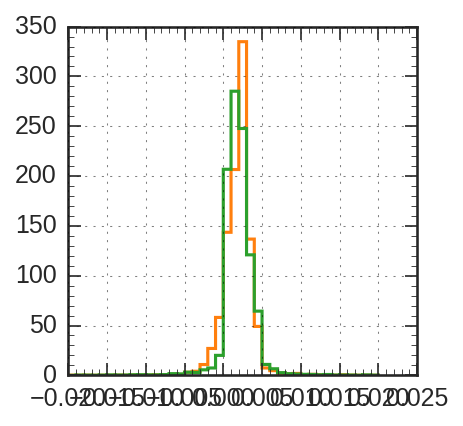

In [43]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

### ME1/1a

In [44]:
apply_correction = False
gems = outs_gem_me11a
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(4758,) (11673,) (1127,) (2829,)
0.008068265612825545 0.0036802230206784683 0.0020036957975794116 0.0009078303267266369


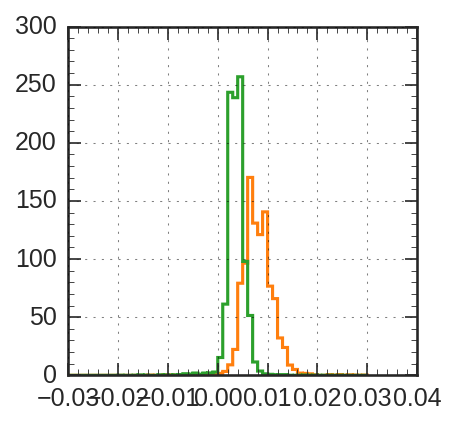

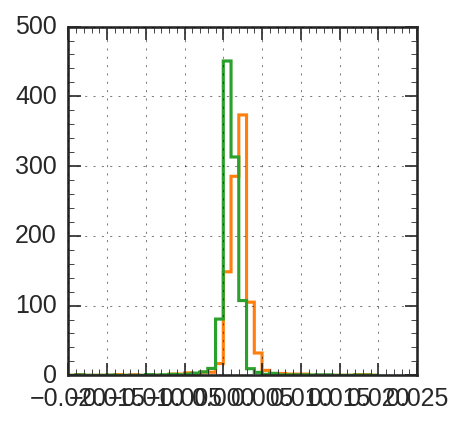

In [45]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

In [46]:
apply_correction = True
gems = outs_gem_me11a
patt_corr_const = (1707. / 1024.)  # ME1/1a
bend_corr_const = [-1.6419, 1.6012]  # ME1/1a (r,f)
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(4758,) (11673,) (1127,) (2829,)
0.006048738459220084 0.005553091538667073 0.0014355991274168087 0.0012806690134081168


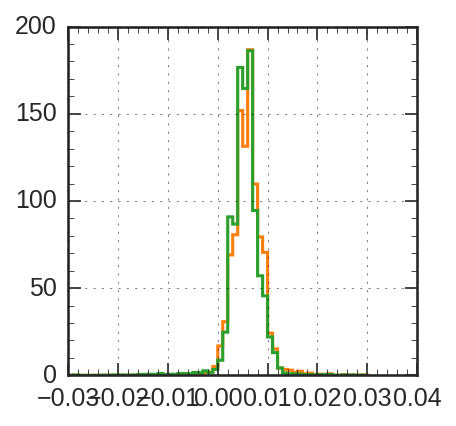

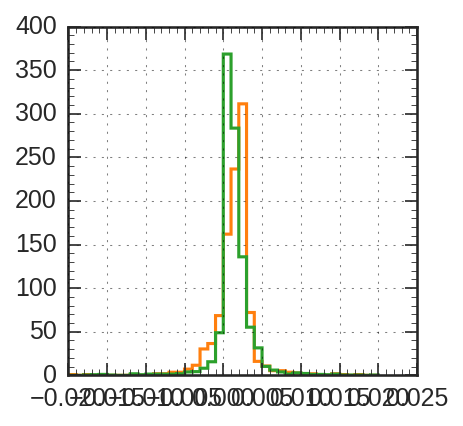

In [47]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

### ME1/2

In [48]:
apply_correction = False
gems = outs_gem_me12
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(6890,) (6079,) (1572,) (2042,)
0.042010632384959876 0.03486045636195374 0.009499017368731648 0.008313818625929894


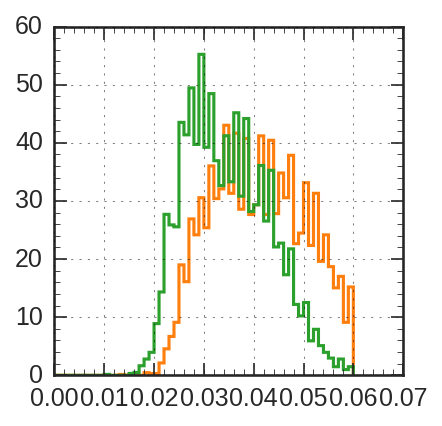

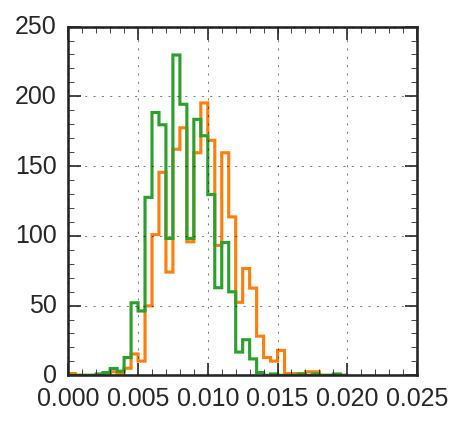

In [49]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

In [50]:
apply_correction = True
gems = outs_gem_me12
patt_corr_const = (1024. / 1024.)  # ME1/2
bend_corr_const = [-0.9237, 0.8287]  # ME1/2 (r,f)
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(6890,) (6079,) (1572,) (2042,)
0.03853052860552368 0.03772569803961226 0.008677424718301747 0.008897731832257411


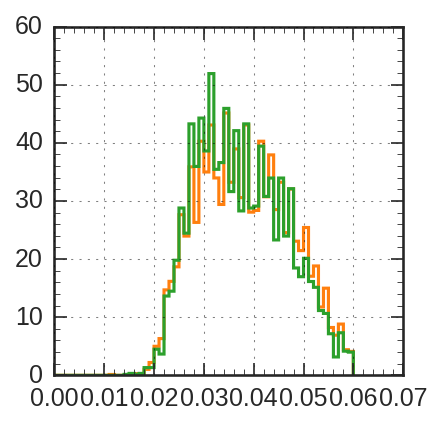

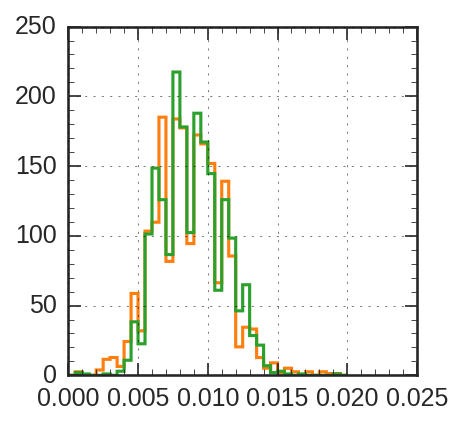

In [51]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()